In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import math
import os
import pandas as pd
import pyarrow.parquet as pq
import pyarrow as pa
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import LogLocator
from matplotlib.patches import Patch
import xarray as xr 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from shapely.ops import unary_union
from shapely.geometry import Polygon, MultiPolygon
from functools import reduce
import cartopy.feature as cfeature
import datetime 
import pytz
import csv
import seaborn as sns
from scipy.stats import kde
from scipy.stats import gaussian_kde
import plotly.express as px
from haversine import haversine
from cartopy.geodesic import Geodesic
import shapely.geometry as sgeom
import netCDF4
import xskillscore as xs
import geopandas as gpd
from scipy import stats
import rioxarray 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm
import matplotlib.colors as colors
proj = ccrs.PlateCarree()

#External functions 
import fct.fct_link_storm_claim as fct_link_storm_claim
import fct.preprocess_sinclim as preprocess_sinclim
import fct.fct_plot_claims as fct_plot_claims
from fct.paths import *

path_save_fig = PATH_FIGURE+"sensitivity_radius/"

In [ ]:
path_save_fig

# Sensitivity of the results to the radius of influence 

In [18]:
sinclim = {}

df_storm_impact = {}
df_info_storm_impact = {}
df_storm_cluster = {}
df_info_mult_cluster = {}

In [19]:
period = "1979-2024WIN"
df_info_storm                       = pd.read_csv(PATH_TRACKS+"tracks_ALL_24h_"+period+"_info.csv", encoding='utf-8')
df_info_storm['storm_landing_date'] = pd.to_datetime(df_info_storm['storm_landing_date'])
df_storm                            = pd.read_csv(PATH_TRACKS+"tracks_ALL_24h_"+period+".csv", encoding='utf-8')
print(f"{df_info_storm.storm_id.nunique()} number of storms")

# df_info_storm_SSI = pd.read_csv(PATH_TRACKS+"tracks_FR_ALL_24h_1979-2024WIN_info_SSI-wgust-q98_r1300.csv", encoding="utf-8")
# df_info_storm_SSI = df_info_storm_SSI.rename(columns={'SSI_FRA_wgust_q98' : "SSI_FRA"})
# df_info_storm = pd.merge(df_info_storm, df_info_storm_SSI[['storm_id', 'SSI_FRA']], on='storm_id')

9881 number of storms


In [20]:
########## IMPACT DATA 
window        = 'd-3_d+3'
min_claim     = 50
method        = 'wgust'
year_start    = 1997
year_end      = 2024
# r             = 1300
# period = "1998-2024"

for r in [900, 1100, 1300] : #[900, 1100, 1300
    print(r)
    sinclim[r] = preprocess_sinclim.open_sinclim_associated(PATH_GENERALI, window, min_claim, method, f"{year_start}-{year_end}", r, False)
    stormi_impact = sinclim[r].storm_id.unique()
    print(f"{len(stormi_impact)} storms with {len(sinclim[r])} impacts")
    

    df_info_storm_impact[r] = df_info_storm.loc[df_info_storm.storm_id.isin(stormi_impact)]
    df_storm_impact[r]      = df_storm.loc[df_storm.storm_id.isin(stormi_impact)]

    #Add storm_landing date and SSI
    sinclim[r] = pd.merge(sinclim[r], df_info_storm_impact[r], on='storm_id', how='left')
    sinclim[r] = pd.merge(sinclim[r], df_info_storm_impact[r], on='storm_id', how='right')

    #Load clusters 
    windi = 96
    r_clust     = 700

    df_storm_cluster[r]                            = pd.read_csv(PATH_TRACKS+f"tracks_ALL_24h_impact_{window}unique-{method}_min{min_claim}_r{r}_clust-mult-2storms-{windi}h_r{r_clust}_{period}.csv", encoding='utf-8')
    df_info_mult_cluster[r]                       = pd.read_csv(PATH_TRACKS+f"tracks_ALL_24h_impact_{window}unique-{method}_min{min_claim}_r{r}_clust-mult-2storms-{windi}h_r{r_clust}_{period}_info.csv", encoding='utf-8')
    df_info_mult_cluster[r]['storm_landing_date'] = pd.to_datetime(df_info_mult_cluster[r]['storm_landing_date'])

#     df_info_mult_cluster[r] = pd.merge(df_info_mult_cluster[r], df_info_storm[['storm_id', 'SSI_FRA']], on="storm_id", how="left")

900
339 storms with 197826 impacts
1100
332 storms with 199049 impacts
1300
335 storms with 199684 impacts


In [21]:
########## IMPACT DATA 
sinclim["varying"] = preprocess_sinclim.open_sinclim_associated(PATH_GENERALI, window, min_claim, method, f"{year_start}-{year_end}", r, True)
stormi_impact_varying = sinclim["varying"].storm_id.unique()

df_info_storm_impact["varying"] = df_info_storm.loc[df_info_storm.storm_id.isin(stormi_impact_varying)]
df_storm_impact["varying"]      = df_storm.loc[df_storm.storm_id.isin(stormi_impact_varying)]
print(f"{df_info_storm_impact['varying'].storm_id.nunique()} storms with impact (Varying radius)")

#Add storm_landing date and SSI
sinclim["varying"] = pd.merge(sinclim["varying"], df_info_storm_impact["varying"], on='storm_id', how='left')

#Load clusters 
windi = 96
r     = 700

df_storm_cluster["varying"]                           = pd.read_csv(PATH_TRACKS+"tracks_ALL_24h_impact_"+window+"unique-"+method+"_min"+str(min_claim)+"_clust-mult-2storms-"+str(windi)+"h_r-varying_"+period+".csv", encoding='utf-8')
df_info_mult_cluster["varying"]                       = pd.read_csv(PATH_TRACKS+"tracks_ALL_24h_impact_"+window+"unique-"+method+"_min"+str(min_claim)+"_clust-mult-2storms-"+str(windi)+"h_r-varying_"+period+"_info.csv", encoding='utf-8')
df_info_mult_cluster["varying"]['storm_landing_date'] = pd.to_datetime(df_info_mult_cluster["varying"]['storm_landing_date'])

# df_info_mult_cluster["varying"] = pd.merge(df_info_mult_cluster["varying"], df_info_storm[['storm_id', 'SSI_FRA']], on="storm_id", how="left")

330 storms with impact (Varying radius)


In [22]:
# Import raw sinclim data 
sinclim_pq = pq.read_table(PATH_GENERALI+'sinclim_v2.1_anom.parquet')

sinclim_pd      =  sinclim_pq.to_pandas(date_as_object = True, safe = False)
sinclim_pd_sort = sinclim_pd.sort_values('dat_sin')
type_claim = ['tempete']

### Filter the sinclim data
sinclim_raw = fct_link_storm_claim.claims_preprocess(sinclim_pd_sort, type_claim)
sinclim_raw['dat_sin'] = pd.to_datetime(sinclim_raw['dat_sin'])

#Remove grave sinisters 
sinclim_raw = sinclim_raw.loc[sinclim_raw.num_chg_brut < 150000]

#Remove negative losses
sinclim_raw = sinclim_raw.loc[sinclim_raw.num_chg_brut > 0]

#Remove the inflation
insee_coeff      = pd.read_csv(PATH_GENERALI+'insee_constant_euros.csv', sep=";")
columns_year = [str(y) for y in range(2024, 1996, -1)]
inflation_data = {
    'year': columns_year,
    'coef_inflation': insee_coeff.loc[0,columns_year].tolist()
}
inflation_data = pd.DataFrame(inflation_data)
inflation_data.coef_inflation = inflation_data.coef_inflation.astype(float).fillna(0.0)
inflation_data.year = inflation_data.year.astype(int).fillna(0.0)

sinclim_raw = sinclim_raw.rename(columns={"survenance" : "year"})
sinclim_raw = pd.merge(sinclim_raw, inflation_data, on='year', how='left')
sinclim_raw['num_chg_brut_cst'] = sinclim_raw['num_chg_brut'] * sinclim_raw['coef_inflation']/100

# Remove potential duplicates 
sinclim_raw = sinclim_raw.drop_duplicates()

## % of claims and losses captured 

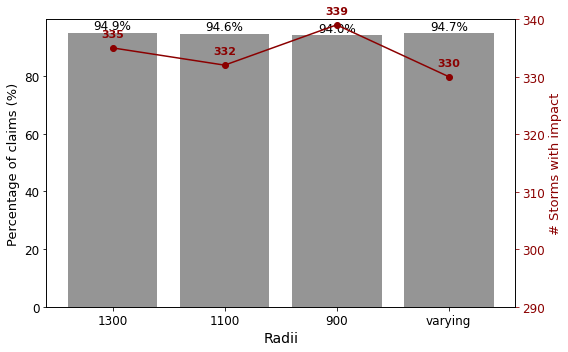

In [23]:
# Compute the % of claims for each sinclim subset
r_order = [1300, 1100, 900, "varying"]
percent_claims = {str(r): sinclim[r].cod_sin.nunique() / sinclim_raw.cod_sin.nunique() * 100 for r in r_order}
nb_storm = {str(r) : df_storm_impact[r].storm_id.nunique() for r in r_order}

# Create the bar plot
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.bar(percent_claims.keys(), percent_claims.values(), color='dimgray', alpha=0.7)

# Plot the number of storms associated with impact 
ax2 = ax.twinx()
ax2.plot(nb_storm.keys(), nb_storm.values(), color="darkred")
ax2.scatter(nb_storm.keys(), nb_storm.values(), color="darkred")
ax2.set_ylim(290, 340)
ax2.set_ylabel('# Storms with impact', fontsize=13)
ax2.yaxis.label.set_color('darkred') 
ax2.tick_params(axis='y', colors='darkred')

# Labels and title
ax.set_xlabel("Radii", fontsize=14)
ax.set_ylabel("Percentage of claims (%)", fontsize=13)
# ax.set_title("Percentage of claims per sinclim subset")
# ax.set_xticks(rotation=45)

# --- Add % claims from total claims set ---
for i, (key, val) in enumerate(percent_claims.items()):
    ax.text(i, val + 0.2, f"{val:.1f}%", ha='center', va='bottom', fontsize=12)

# --- Add number of storms above red points ---
for i, (key, val) in enumerate(nb_storm.items()):
    ax2.text(i, val + 1.5, f"{val}", ha='center', va='bottom', color='darkred', fontsize=11, fontweight='bold')
    
# Increase fontsize 
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)

fig.tight_layout()
fig.savefig(path_save_fig+"perc_sinclim_claims_nb_storms.png", 
            transparent=True, bbox_inches='tight', dpi=300)
fig.savefig(path_save_fig+"perc_sinclim_claims_nb_storms.svg", 
            format="svg", bbox_inches="tight", dpi=300, transparent=True)
fig.savefig(path_save_fig+"perc_sinclim_claims_nb_storms.pdf", 
            format="pdf", bbox_inches="tight", dpi=300, transparent=True)
plt.show()

## In number of storms & cluster

In [24]:
metrics = ["Claims associated" , "Impacting storms in clusters", "Claims in clusters", "Total cost in clusters"]

# Prepare a dictionary to store percentages per metric per key
data = {metric: [] for metric in metrics}

r_order = [1300, 1100, 900, "varying"]
for key in r_order:
    # Percentage of claims from raw dataset 
    pct_sinclim = sinclim[key].cod_sin.nunique() / sinclim_raw.cod_sin.nunique() * 100
    
    # Unique storms in cluster by this key
    storm_id_clust = df_info_mult_cluster[key].storm_id.unique()
    pct_cluster = (df_info_mult_cluster[key].storm_id.nunique() / df_info_storm_impact[key].storm_id.nunique()) * 100
    
    # Claims in cluster (count occurrences in sinclim)
    pct_claims = (sinclim[key].loc[sinclim[key]["storm_id"].isin(storm_id_clust)].cod_sin.nunique() / sinclim[key].cod_sin.nunique()) * 100
    
    # Total cost in cluster (sum over 'num_chg_brut_cst')
    total_cost = sinclim[key]["num_chg_brut_cst"].sum()#sum(d.get("num_chg_brut_cst", 0) for d in sinclim)
    cluster_cost = sinclim[key].loc[sinclim[key]["storm_id"].isin(storm_id_clust)]["num_chg_brut_cst"].sum()#sum(d.get("num_chg_brut_cst", 0) for d in sinclim if d[key][] in cluster_ids)
    pct_cost = (cluster_cost / total_cost) * 100 if total_cost else 0
    
    # Save into dict
    data["Claims associated"].append(pct_sinclim)
    data["Impacting storms in clusters"].append(pct_cluster)
    data["Claims in clusters"].append(pct_claims)
    data["Total cost in clusters"].append(pct_cost)

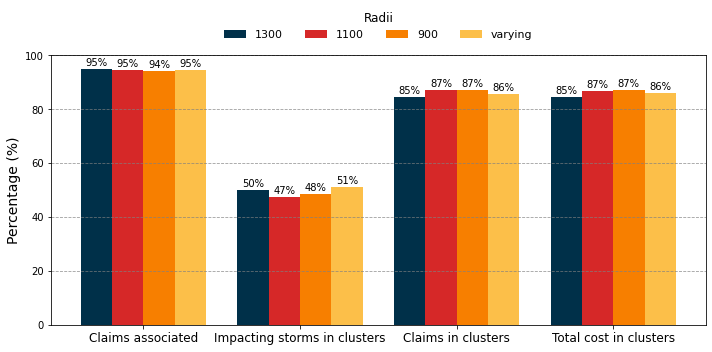

In [26]:
# Convert to DataFrame for plotting
df_plot = pd.DataFrame(data, index=r_order)

# --- Plot grouped bar chart ---
fig, ax = plt.subplots(figsize=(10, 5))

x = range(len(metrics))
bar_width = 0.8 / len(r_order)  # divide space between number of keys
radius_colors = {1300 : "#003049", 1100 : "#d62828", 900 : "#f77f00", 'varying' : "#fcbf49"}

for i, key in enumerate(r_order):
    values = df_plot.loc[key].values
    ax.bar([p + i*bar_width - (len(r_order)-1)*bar_width/2 for p in x], values, bar_width, label=str(key), color=radius_colors[key])

ax.set_xticks(x)
# ax.set_xticklabels(metrics, rotation=15, ha="right", fontsize=14)
ax.set_xticklabels(metrics, fontsize=12)
# ax.tick_params("x", rotation=15)
ax.set_ylim(0, 100)
ax.set_ylabel("Percentage (%)", fontsize=14)
# ax.set_yticklabels(fontsize=10)
# ax.set_title("Cluster Metrics by Key")

# Add text labels
for i, key in enumerate(r_order):
    for j, v in enumerate(df_plot.loc[key]):
        ax.text(j + i*bar_width - (len(r_order)-1)*bar_width/2, v + 0.5, f"{v:.0f}%", ha="center", va="bottom", fontsize=10)
        
ax.legend(
    title="Radii", 
    fontsize=11, 
    title_fontsize=12, 
    loc="upper center", 
    bbox_to_anchor=(0.5, 1.2),  # center, above the plot
    ncol=4,                      # all keys on one line
    frameon=False
)
ax.grid(axis="y", linestyle="--", alpha=0.8, color="gray")

# plt.grid(True)
fig.tight_layout()
fig.savefig(path_save_fig+"perc_summary.png", 
            transparent=True, bbox_inches='tight', dpi=300)
fig.savefig(path_save_fig+"perc_summary.svg", 
            format="svg", bbox_inches="tight", dpi=300, transparent=True)
fig.savefig(path_save_fig+"perc_summary.pdf", 
            format="pdf", bbox_inches="tight", dpi=300, transparent=True)
plt.show()